In [1]:
import pandas as pd
import random
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
random.seed(1098)

In [2]:
# read in the first file
df1 = pd.read_csv('student.record.csv')

In [3]:
df1.head()

,MAJOR3_DESCR,MAJOR2_DESCR,MAJOR1_DESCR,HSGPA,LAST_ACT_ENGL_SCORE,LAST_ACT_MATH_SCORE,LAST_ACT_READ_SCORE,LAST_ACT_SCIRE_SCORE,LAST_ACT_COMP_SCORE,LAST_SATI_VERB_SCORE,...,STDNT_GROUP1,STDNT_GROUP2,MAJOR1_DEPT,MAJOR2_DEPT,MAJOR3_DEPT,ANONID,ADMIT_TERM,MAJOR1_TERM,MAJOR2_TERM,MAJOR3_TERM
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
1,NaN,NaN,Asian Studies BA,3.8,25.0,22.0,29.0,28.0,26.0,NaN,...,NaN,NaN,Asian Languages And Cultures,NaN,NaN,2,110.0,123.0,NaN,NaN
2,NaN,NaN,Psychology BA,3.3,NaN,NaN,NaN,NaN,NaN,NaN,...,E,NaN,Psychology Department,NaN,NaN,4,63.0,79.0,NaN,NaN
3,NaN,NaN,Civil Engineering BSE,3.9,33.0,32.0,28.0,30.0,31.0,NaN,...,NaN,NaN,Civil & Environmental Engr,NaN,NaN,6,106.0,125.0,NaN,NaN
4,NaN,NaN,NaN,3.8,24.0,22.0,18.0,18.0,21.0,610.0,...,C,NaN,NaN,NaN,NaN,7,83.0,NaN,NaN,NaN


In [4]:
# the second file
df2 = pd.read_csv('student.course.csv.zip', compression='zip')

In [5]:
df2.head()

,ANONID,SUBJECT,CATALOG_NBR,GRD_PTS_PER_UNIT,GPAO,DIV,ANON_INSTR_ID,TERM
0,26,ACC,272,2.0,3.343636,P,2920,79
1,114,ACC,272,2.0,2.817857,P,2920,83
2,121,ACC,272,4.0,4.000000,P,201,111
3,125,ACC,272,1.3,3.639063,P,3360,84
4,180,ACC,272,3.0,3.846154,P,2920,107


In [6]:
#For the second dataset, I ran a small OLS of grades on GPA to see the correlation
print(smf.ols(formula='GRD_PTS_PER_UNIT ~ GPAO', data=df2).fit().summary())

                            OLS Regression Results                            
Dep. Variable:       GRD_PTS_PER_UNIT   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                 4.959e+05
Date:                Wed, 07 Jun 2017   Prob (F-statistic):               0.00
Time:                        09:49:40   Log-Likelihood:            -1.6057e+06
No. Observations:             1327065   AIC:                         3.211e+06
Df Residuals:                 1327063   BIC:                         3.211e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1259      0.004     29.763      0.0

There is less valuable information from the second dataset that I can use for this analysis. I will use solely the first dataset for this mini project. First I notice the high correlation between SAT math score and ACT math score. To reduce endogeneity problems in regression, I will only consider ACT scores.

In [7]:
df1[['LAST_ACT_MATH_SCORE','LAST_SATI_MATH_SCORE']].corr()

,LAST_ACT_MATH_SCORE,LAST_SATI_MATH_SCORE
LAST_ACT_MATH_SCORE,1.000000,0.793317
LAST_SATI_MATH_SCORE,0.793317,1.000000


In [8]:
print(smf.ols(formula='LAST_ACT_MATH_SCORE ~ C(SEX) + HSGPA + LAST_ACT_ENGL_SCORE + LAST_ACT_READ_SCORE + LAST_ACT_SCIRE_SCORE + LAST_ACT_COMP_SCORE', data=df1).fit().summary())

                             OLS Regression Results                            
Dep. Variable:     LAST_ACT_MATH_SCORE   R-squared:                       0.903
Model:                             OLS   Adj. R-squared:                  0.903
Method:                  Least Squares   F-statistic:                 9.932e+04
Date:                 Wed, 07 Jun 2017   Prob (F-statistic):               0.00
Time:                         09:49:41   Log-Likelihood:            -1.0898e+05
No. Observations:                64110   AIC:                         2.180e+05
Df Residuals:                    64103   BIC:                         2.180e+05
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

The output shows statistical significance of all independent variables on the ACT Math score. Pay attention to sex variable (male/female), which shows the positive effect (higher math score) on average if a student is male.

The other ACT scores of verbal and writing exams are otherwise negatively associated with the scores of ACT math. So if one does well in math, it’s likely that he/she might not do that well on other subjects on average.

Now I use create a new variable STEM_major, which categorizes majors into STEM (=1) or non-STEM (=0). First, I need to list all unique majors from the column majors. Then I construct a list of STEM majors from this list. Last, I set up a new variable: for each observation if a major is STEM, the variable is assigned to 1, otherwise 0.


In [9]:
df1['MAJOR1_DESCR'].unique().shape, df1['MAJOR1_DESCR'].unique()

((349,),
 array([nan, 'Asian Studies BA', 'Psychology BA', 'Civil Engineering BSE',
        'American Culture BA', 'Anthropology BA',
        'Chemical Engineering BSE', 'Environ Policy & Behavior BS',
        'Communication BA', 'Computer Science BSE',
        'Industrial & Oper Eng BSE', 'Mechanical Engineering BSE',
        'General Studies BGS', 'Architecture BS', 'Mathematics BS',
        "Women's Studies BA", 'Computer Engineering BSE', 'History BA',
        'Brain,Behavior & Cognit Sc BS', 'English BA', 'Psychology BS',
        'History of Art BA', 'Spanish BA', 'Sociology BA', 'Economics BA',
        'General Biology BS', 'Aerospace Engineering  BSE',
        'Film and Video Studies BA', 'Nursing BS Fresh',
        'Electrical Engineering BSE', 'Biology BS',
        'International Studies BA', 'Chemistry BSChem',
        'Political Science BA', 'Business Administration BBA',
        'Microbiology BS', 'Individualized Concentrat BA',
        'Cellular & Molec Biology BS', 'Graph

In [10]:
STEM =['Civil Engineering BSE', 'Chemical Engineering BSE','Computer Science BSE','Industrial & Oper Eng BSE', 
       'Mechanical Engineering BSE','Architecture BS', 'Mathematics BS','Computer Engineering BSE','Brain,Behavior & Cognit Sc BS',
      'General Biology BS', 'Aerospace Engineering  BSE','Electrical Engineering BSE', 'Biology BS','Chemistry BSChem',
      'Microbiology BS','Cellular & Molec Biology BS','Biopsych, Cognit & Neurosci BS','Mathematics BA','Biopsych, Cognit & Neurosci BA',
      'Biopsych & Cognit Science BS', 'Computer Science BS','Biomedical Engineering BSE','Biochemistry BS','Materials Science & Engin BSE',
      'Neuroscience BS','Nursing R N-BSN-MS','Chemistry BS','Oceanography BS','Movement Science BS', 'Informatics BA',
        'Physics BS', 'Nursing BS Soph Transfer', 'Ecology & Evolut Biology BS', 'Nuclear Eng & Radiolog Sc BSE','Brain,Behavior & Cognit Sc BA',
      'Dental Hygiene BS', 'Interdisciplinary Physics BS','Naval Arch & Marine Eng BSE','Engineering BS', 'Biology BA','Environmental Engineering BSE', 'Earth Sys Sc & Eng BSE',
        'Earth Sciences BS','Informatics BS', 'Biomolecular Science BS','Statistics BS','Geological Sciences  BS','Astronomy & Astrophysics BS', 'Civil & Environmental Eng BSE',
      'Biophysics BS','Environmental Geosciences BS', 'General Physics BS','Earth & Environmental Sci BS', 'Biopsych & Cognit Science BA',
        'Engineering Physics BSE', 'Plant Biology BS', 'Oceanog Mrn Geol & Geochem BS','Biochemistry BSChem','Sustainable Engin BSE Mech E',
      'Kinesiology BS','Cognitive Science BA','Materials & Metallurgical BSE','Meteorology BSE','Earth System Science','Cognitive Science BS',
        'Environmental Geology BS','Information BS', 'Nursing BS WCC Junior Transfer', 'Medical Technology BS','Biomedical Sciences BS',
      'Nuclear Engineering BSE','Sustainable Engin BSE Civ E','Astronomy BS','Pharmaceutical Sciences BS','Physics BSChem','Atmos Ocean & Space Sc BS',
      'Statistics BA', 'Sustainable Engin BSE Chem E','Prog in Global Engin BSE ChemE','Geological Sciences  BA','Prog in Global Engin BSE CompS',
      'Second Career Nursing BS','Computer Science BA','Interdis Chemical Sciences BS','Botany BA','Nat Res - Biophysics BS', 'Atmospheric & Oceanic Sci BS',
        'Cellular & Molec Biol BSChem', 'Botany BS', 'Eng Global Lead Hon BSE Mat Sc', 'Earth Sciences BA','Chemical Science BS',
      'Meteorology BS','Engineering Science BSE', 'Nursing R N-BSN Ann Arbor', 'Eng Global Lead Hon BSE Comp E', 'Sustainable Engin BSE Ind Op',
      'Nursing BS Soph JCC Transfer','Eng Global Lead Hon BSE Aero', 'Interdisciplinary Astronomy BS', 'Nat Res - Sociobehavior BS',
     'Prog in Global Engin BSE Mat S', 'Neuroscience BS Chem','Mathematics BSChem','Plant Biology BSChem', 'Interdisciplinary Physics BA',
      'Sustainable Engin BSE Aero', 'Interdisc Physics BSChem', 'Nursing BS Fresh Transfer', 'Cellular & Molec Biology BA', 'Astronomy & Astrophysics BA',
        'Natural Resources BS','Sustainable Engin BSE Env E','Computer & Commun Science BS', 'Computer Science BS Chem']

In [11]:
len(STEM) #there are 115 STEM majors in this list

115

In [12]:
df1.insert(column='STEM_major', loc=0,value=0) # put the variable into the data frame

In [13]:
df1.head() #now we have a new dataset with a variable STEM_major of values 0

,STEM_major,MAJOR3_DESCR,MAJOR2_DESCR,MAJOR1_DESCR,HSGPA,LAST_ACT_ENGL_SCORE,LAST_ACT_MATH_SCORE,LAST_ACT_READ_SCORE,LAST_ACT_SCIRE_SCORE,LAST_ACT_COMP_SCORE,...,STDNT_GROUP1,STDNT_GROUP2,MAJOR1_DEPT,MAJOR2_DEPT,MAJOR3_DEPT,ANONID,ADMIT_TERM,MAJOR1_TERM,MAJOR2_TERM,MAJOR3_TERM
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
1,0,NaN,NaN,Asian Studies BA,3.8,25.0,22.0,29.0,28.0,26.0,...,NaN,NaN,Asian Languages And Cultures,NaN,NaN,2,110.0,123.0,NaN,NaN
2,0,NaN,NaN,Psychology BA,3.3,NaN,NaN,NaN,NaN,NaN,...,E,NaN,Psychology Department,NaN,NaN,4,63.0,79.0,NaN,NaN
3,0,NaN,NaN,Civil Engineering BSE,3.9,33.0,32.0,28.0,30.0,31.0,...,NaN,NaN,Civil & Environmental Engr,NaN,NaN,6,106.0,125.0,NaN,NaN
4,0,NaN,NaN,NaN,3.8,24.0,22.0,18.0,18.0,21.0,...,C,NaN,NaN,NaN,NaN,7,83.0,NaN,NaN,NaN


In [14]:
# assigne STEM_major = 1 if a major is in the list STEM
for i in range(len(df1)):
    if (df1.iloc[i,2] in STEM) | (df1.iloc[i,3] in STEM):
        df1.set_value(index=i, col ='STEM_major',value=1)

In [15]:
df1.head()

,STEM_major,MAJOR3_DESCR,MAJOR2_DESCR,MAJOR1_DESCR,HSGPA,LAST_ACT_ENGL_SCORE,LAST_ACT_MATH_SCORE,LAST_ACT_READ_SCORE,LAST_ACT_SCIRE_SCORE,LAST_ACT_COMP_SCORE,...,STDNT_GROUP1,STDNT_GROUP2,MAJOR1_DEPT,MAJOR2_DEPT,MAJOR3_DEPT,ANONID,ADMIT_TERM,MAJOR1_TERM,MAJOR2_TERM,MAJOR3_TERM
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
1,0,NaN,NaN,Asian Studies BA,3.8,25.0,22.0,29.0,28.0,26.0,...,NaN,NaN,Asian Languages And Cultures,NaN,NaN,2,110.0,123.0,NaN,NaN
2,0,NaN,NaN,Psychology BA,3.3,NaN,NaN,NaN,NaN,NaN,...,E,NaN,Psychology Department,NaN,NaN,4,63.0,79.0,NaN,NaN
3,1,NaN,NaN,Civil Engineering BSE,3.9,33.0,32.0,28.0,30.0,31.0,...,NaN,NaN,Civil & Environmental Engr,NaN,NaN,6,106.0,125.0,NaN,NaN
4,0,NaN,NaN,NaN,3.8,24.0,22.0,18.0,18.0,21.0,...,C,NaN,NaN,NaN,NaN,7,83.0,NaN,NaN,NaN


In [16]:
# rerun the regression
print(smf.ols(formula='LAST_ACT_MATH_SCORE ~ C(SEX) + HSGPA + LAST_ACT_ENGL_SCORE + LAST_ACT_READ_SCORE + LAST_ACT_SCIRE_SCORE + LAST_ACT_COMP_SCORE + C(STEM_major)', data=df1).fit().summary())

                             OLS Regression Results                            
Dep. Variable:     LAST_ACT_MATH_SCORE   R-squared:                       0.904
Model:                             OLS   Adj. R-squared:                  0.904
Method:                  Least Squares   F-statistic:                 8.578e+04
Date:                 Wed, 07 Jun 2017   Prob (F-statistic):               0.00
Time:                         09:50:28   Log-Likelihood:            -1.0876e+05
No. Observations:                64110   AIC:                         2.175e+05
Df Residuals:                    64102   BIC:                         2.176e+05
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

Those of STEM majors also tend to do well in Math (reasonably) on average, and likely being male (another regression made to learn of the correlation).


In [17]:
print(smf.ols(formula='STEM_major ~ C(SEX) + HSGPA', data=df1).fit().summary())

                            OLS Regression Results                            
Dep. Variable:             STEM_major   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1037.
Date:                Wed, 07 Jun 2017   Prob (F-statistic):               0.00
Time:                        09:50:29   Log-Likelihood:                -76497.
No. Observations:              125222   AIC:                         1.530e+05
Df Residuals:                  125219   BIC:                         1.530e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1916      0.003     56.690      

Now I flip the equation around. I assume female and male are labels to be classified based on the charisteristics (or features) of their high school GPAs, ACT scores. In other words, if I have information above of an individual, may I be able to guess the person's gender? 

In [18]:
df = df1[['SEX','LAST_ACT_MATH_SCORE','LAST_ACT_ENGL_SCORE', 'LAST_ACT_READ_SCORE','LAST_ACT_SCIRE_SCORE','LAST_ACT_COMP_SCORE','HSGPA','STEM_major']].dropna()
x = df.iloc[:,1:].values
y = df['SEX'].values
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state=34)
df.head()

,SEX,LAST_ACT_MATH_SCORE,LAST_ACT_ENGL_SCORE,LAST_ACT_READ_SCORE,LAST_ACT_SCIRE_SCORE,LAST_ACT_COMP_SCORE,HSGPA,STEM_major
1,F,22.0,25.0,29.0,28.0,26.0,3.8,0
3,F,32.0,33.0,28.0,30.0,31.0,3.9,1
4,F,22.0,24.0,18.0,18.0,21.0,3.8,0
5,F,22.0,31.0,34.0,22.0,27.0,3.9,0
6,M,34.0,29.0,28.0,36.0,32.0,4.0,0


In [19]:
# how accurate the prediction of male and female based on these variables?

# decision tree algorithm (%)
DecisionTreeClassifier().fit(xtrain,ytrain).score(xtest,ytest) * 100

57.362345967867725

In [20]:
# support vector machine algorithm (%)
SVC(kernel="linear", C=0.025).fit(xtrain,ytrain).score(xtest,ytest) * 100

66.011542661051308

In [21]:
# Naive Bayes algorithm (%)
GaussianNB().fit(xtrain,ytrain).score(xtest,ytest) * 100

62.564342536265791

In [22]:
# K-nearest neighbors algorithm (%)
KNeighborsClassifier(n_neighbors=3).fit(xtrain,ytrain).score(xtest,ytest) * 100

59.920449227889563

Modifying this [code](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) a bit, I want to see the overall comparision of classification algorithms for this dataset. For the 2D graph plotting, I decide to use only high school GPAs and ACT Math scores for demonstration.

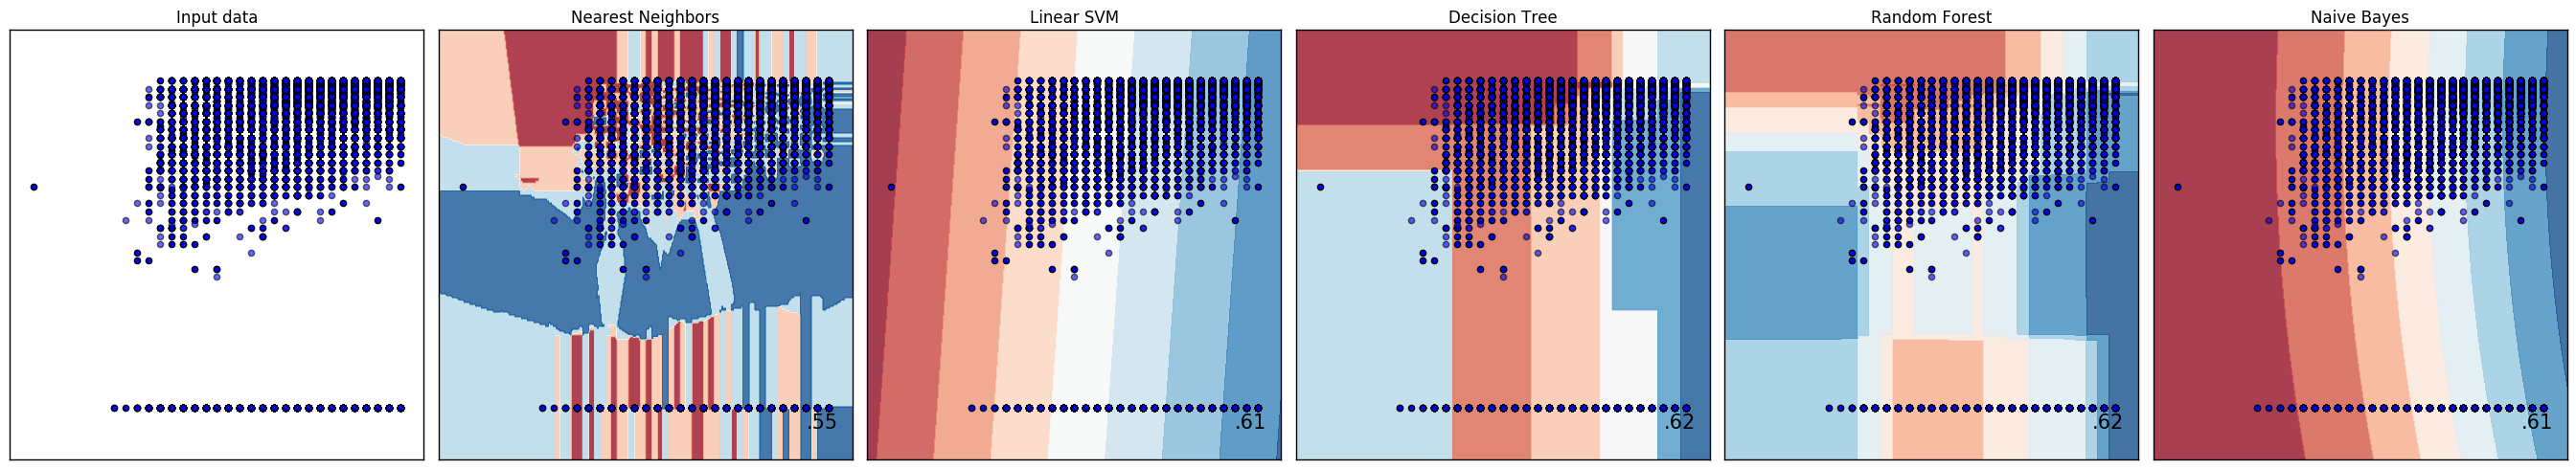

In [23]:
h = .02  # step size in the mesh
names = ["Nearest Neighbors", "Linear SVM", "Decision Tree", "Random Forest", "Naive Bayes"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    GaussianNB()]
figure = plt.figure(figsize=(27, 5))
i = 1
# iterate over datasets
X= x[:,[0,5]]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, len(classifiers) + 1, i)
ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], cmap=cm_bright)
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], cmap=cm_bright, alpha=0.6)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1
# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    ax.scatter(X_train[:, 0], X_train[:, 1],  cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1],  cmap=cm_bright,  alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
    i += 1

plt.tight_layout()
plt.show()

The top titles are Input Data (our 1st dataset), and the algorithms of Nearest Neighbors, Linear SVM, Decision Tree, Random Forest, and Naive Bayes. On the right bottom corners are the accuracy scores of these methods in classifcation: .56, .61, .62, .61 (the maximum value is 1) respectively. Not the best results for classification, but it indicates the possible correlation between ACT score math and gender status.

x-axis is ACT Math scores and y-axis is high school GPAs.

The odd horizontal line of High School GPAs could be investigated by looking the histograms below. As one could see our dataset contains lots of good students  with GPA >3.5 and very weird outliers of < 0.5. I think they are missing data (inputs=0) or outliers in this case.

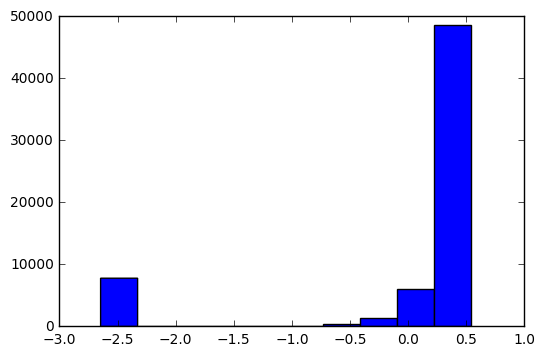

In [24]:
# High School GPAs
plt.hist(X[:,1])
plt.show()

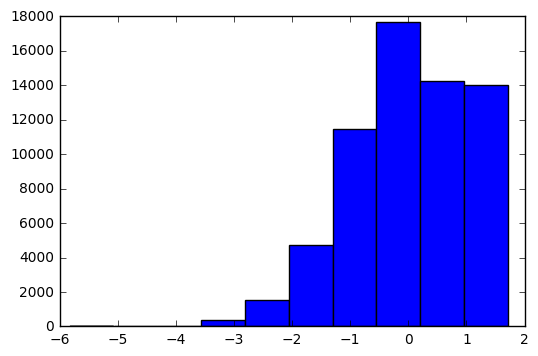

In [25]:
# ACT math score histogram behaves approximately normal to me (skewed)
plt.hist(X[:,0])
plt.show()